# Research topic:   探討Ptt鄉民對於躺平族的的討論與看法



### 躺平族情境介紹：
躺平族是指：放棄遠大的生活目標過著低慾望的生活，收入只需維持生存的最低標準，強調低收入低消費以及及時行樂。


「你人生奮鬥的終點，是別人的起點」，這一句話道出了現在年輕人的掙扎無力感，當你人生不順遂，一路逆風努力了一輩子，發現成就還是不如別人，那還不如對自己好一點，直接躺平！

躺平族這一概念在近年來ptt掀起討論，象徵著對現代社會壓力和期望的一種抗議或無奈的應對方式。透過分析PTT上的討論，可以深入了解台灣社會對這種現象的看法和感受。
根據媒體研究，台灣人使用「躺平」這個次數在「2021年」快速產生！


### 分析動機：
* 年輕人為何拒絕奮鬥？低消費低生產主義有可能造成國安危機？
* 不再以買房、買車、生小孩為人生目標，「躺平才是唯一的真理」，年輕人對於未來普遍感到失望和無力，探討社會對於躺平現象的接受度和反應
* 分析躺平族現象對經濟活動、就業市場和消費行為的影響（如不消費、低生產），以及它可能對未來經濟發展的影響
* 透過分析PTT閒聊版上的討論，揭露大眾意見的形成與流動過程。分析媒體如何塑造對躺平族的觀點，以及這些觀點在台灣社會中如何傳播與轉變




#Import package

In [1]:
# 安裝會使用到的套件
# %pip install ckiptagger[tf,gdown] wordcloud SnowNLP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import time
from datetime import datetime, timedelta
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# 設定字型
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' 

### Agonda

+ 1. 資料前置作業
    - 1.1 資料前處理
    - 1.2 資料清理
    - 1.3 移除停用字與斷詞
+ 2. CKIP
    + 2.1 使用CKIP進行自然語言處理
    + 2.2 詞性標註-POS
+ 3. 利用SnowNLP進行情緒分析
+ 4. TF-IDF計算
    + 4.1 計算每個詞彙的TF-IDF
    + 4.2 檢視結果
+ 6. 透過結巴斷詞與N-gram幫助建立字典
    + 6.1 Bigram
    + 6.2 Trigram
    + 6.3 Pairwise correlation
    + 6.4 和「躺平」相關性最高的十個詞彙
    + 6.5 計算文章相似度
+ 7. 結論
    



### 1.資料前置作業

#### 1.1 資料前處理

In [4]:
#Import the dataset
MetaData = pd.read_csv('raw_data/Lie-Flat.csv')

#將artDate欄位只留下 年/月/日
MetaData['artDate'] = pd.to_datetime(MetaData['artDate']).dt.date

In [5]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(1)

共有 625 篇文章


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt


### 1.2 資料清理


*   去除NA值
*   正規化資料清理
*   去除不是中文的字詞


In [6]:
#清理文章內容
clear_df = MetaData.copy()
#去除有包含空值的筆數
clear_df.dropna(axis = 0, how = 'any', inplace = True)

#去除不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate','dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)


#移除內文中的網址
clear_df['sentence'] = (
    clear_df['artContent']
    .replace(r'http\S+', '', regex = True)
    .replace(r'www\S+', '', regex = True)
    .replace(r'\d+', '', regex = True)
    .replace(r'\n\n','。', regex=True)
    .replace(r'\n' ,',', regex=True)
)

clear_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"都第集了，\r,竟然沒人開這一檔閒聊，\r,這是一部顛覆的都市情感劇，\r,沒有白富美的女一..."
1,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03,因為在FB滑到[沒有工作的一年]給打工人的15大金句\r\n才開始注意到這部陸劇[沒有工作的...,"因為在FB滑到[沒有工作的一年]給打工人的大金句\r,才開始注意到這部陸劇[沒有工作的一年]..."
2,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30,備註請放最後面 違者新聞文章刪除\r\n\r\n1.媒體來源:\r\n新唐人\r\n\r\n...,"備註請放最後面 違者新聞文章刪除\r,\r,.媒體來源:\r,新唐人\r,\r,.記者署名:..."
3,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,[問卦]我就爛有另一種說法嗎?,2021-06-04,在日本有草食男或啃老族\r\n\r\n現在中國忽然來了一個躺平族\r\n\r\n那有沒有其他...,"在日本有草食男或啃老族\r,\r,現在中國忽然來了一個躺平族\r,\r,那有沒有其他的說法比..."
4,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,Re:[問卦]具體來說現在在等什麼,2021-06-06,依據人性\r\n\r\n1. 人是自私的，自己的利益優先考量\r\n2. 別人的不幸甜如蜜\...,"依據人性\r,\r,. 人是自私的，自己的利益優先考量\r,. 別人的不幸甜如蜜\r,\r,..."
5,https://www.ptt.cc/bbs/Gossiping/M.1623985925....,[問卦]阿姨我不想努力了算不算躺平的掛??,2021-06-18,躺平族 尼特族 日本低慾望 韓國袋鼠族....等\r\n\r\n在台灣1450所造成的內捲下...,"躺平族 尼特族 日本低慾望 韓國袋鼠族....等\r,\r,在台灣所造成的內捲下，名稱還沒有..."
6,https://www.ptt.cc/bbs/Gossiping/M.1624777902....,Re:[問卦]現今社會啃老多嗎?,2021-06-27,日本就一堆了叫啃老族\r\n\r\n美國稱迴力鏢族\r\n\r\n中國叫躺平族\r\n\r\...,"日本就一堆了叫啃老族\r,\r,美國稱迴力鏢族\r,\r,中國叫躺平族\r,\r,台灣也差不..."
7,https://www.ptt.cc/bbs/Gossiping/M.1624811888....,[問卦]人生拚三次躺平退出社會競爭可恥嗎?,2021-06-28,"我有個朋友\r\n人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄\r\n人生拚第二次 三...","我有個朋友\r,人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄\r,人生拚第二次 三年考..."
8,https://www.ptt.cc/bbs/Gossiping/M.1625541063....,Re:[問卦]好手好腳不工作整天接受施捨的叫?,2021-07-06,如果用人來看\r\n\r\n就是一個自宅警備隊\r\n\r\n每天蹲在家不工作\r\n\r\...,"如果用人來看\r,\r,就是一個自宅警備隊\r,\r,每天蹲在家不工作\r,\r,都要靠父母..."
9,https://www.ptt.cc/bbs/Gossiping/M.1625642776....,[問卦]台灣的躺平族或家裡蹲是不是比較少？,2021-07-07,這邊是跟中國日本比，中國開始流行躺平，那日本\r\n\r\n很早就開始有家裡蹲文化，而且老中...,"這邊是跟中國日本比，中國開始流行躺平，那日本\r,\r,很早就開始有家裡蹲文化，而且老中少都..."


### 1.3  斷句斷詞 與移除停用字

斷句

In [7]:
#清理符號
clear_df['sentence'] = clear_df['sentence'].astype(str).str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]
sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都第集了
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,竟然沒人開這一檔閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這是一部顛覆的都市情感劇
6,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,沒有白富美的女一
8,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,也沒有高富帥的男一
10,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,也沒有悲催的北上廣生活
13,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,以女二何小雨躺平族的視角
15,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,來描述女一何大雨人生受挫失業的生活
17,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,女一辣目洋子充分運用她特有的美感
19,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,以及詼諧的演技演繹出北漂族的另外一種酸甜甘苦


斷詞及停用字處理

使用jieba套件進行斷詞與移除停用字

In [8]:
#設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt")
#新增自定義字典
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from c:\Users\a8184\OneDrive\桌面\作品\躺平族資料探勘0\dict\dict.txt ...
Dumping model to file cache C:\Users\a8184\AppData\Local\Temp\jieba.uf0ca3734393a963fcf7189c3052e0a92.cache
Loading model cost 0.749 seconds.
Prefix dict has been built successfully.


In [9]:
#對文章內容進行斷詞處理
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,第集
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,竟然
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,沒人開
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這一
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這是
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,一部
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,顛覆
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都市
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,情感


In [10]:
# 計算詞頻並轉換為DataFrame
word_counts = pd.DataFrame(pd.value_counts(word_df['word'])).reset_index()
word_counts.columns = ['word', 'count']  # 將列名稱正確設置為 'word' 和 'count'

# 根據 'count' 欄位降序排序
freq_df = word_counts.sort_values(by='count', ascending=False)

# 顯示前10條數據
freq_df.head(10)


,word,count
0,躺平,1220
1,台灣,443
2,就是,440
3,自己,431
4,工作,374
5,現在,353
6,沒有,321
7,不是,317
8,可以,314
9,年輕人,290


去除停用字

In [11]:
freq_df = word_counts.sort_values(by='count', ascending=False)
freq_df.head(10)

,word,count
0,躺平,1220
1,台灣,443
2,就是,440
3,自己,431
4,工作,374
5,現在,353
6,沒有,321
7,不是,317
8,可以,314
9,年輕人,290


In [12]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

In [13]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,第集
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,沒人開
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這一
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,一部
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,顛覆
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都市
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,情感
6,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,富美
8,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,富帥


計算詞頻

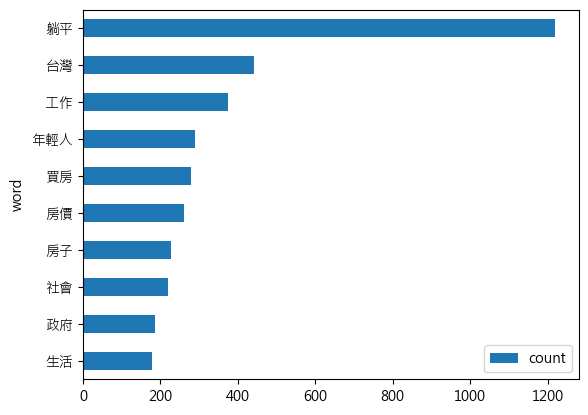

In [14]:
word_counts = pd.value_counts(noStop_df['word']).reset_index()
word_counts.columns = ['word', 'count'] 
freq_df_nostop = word_counts.sort_values(by='count', ascending=False)
freq_df_nostop.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()


*    詞頻的前十名與我們要做的主題高度相關，包含躺平、年輕人、房價等等詞彙，這些詞匯反映了分析文本中的熱門討論話題，可能指向年輕一代面臨的社會和經濟問題，例如：

- 躺平：這個詞彙指的是某些年輕人選擇的一種生活方式，即不追求過度勞累或高消費的生活，而是選擇一種無壓力和隨性的生活方式
- 房價：這是一個普遍關注的話題，尤其是對於在都市中工作生活的年輕人來說，高房價可能是一個重大的經濟負擔

繪製文字雲

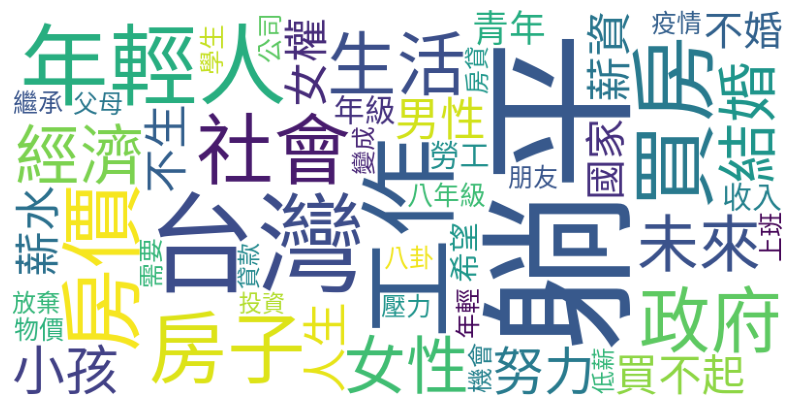

In [15]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

從文字雲我們發現 躺平相關的討論文章中出現了房子、房價、買房、工作、年輕人、台灣以及政府

從這邊我們大概可以推估年輕人躺平的主要原因可能跟台灣的房價有關。

文字雲當中可以看出政府出現的次數也很高，我們推論這可能顯示出年輕人對於政府的打房政策不滿，我們後續進行情緒分析找出負面情緒句子，再深入探討。

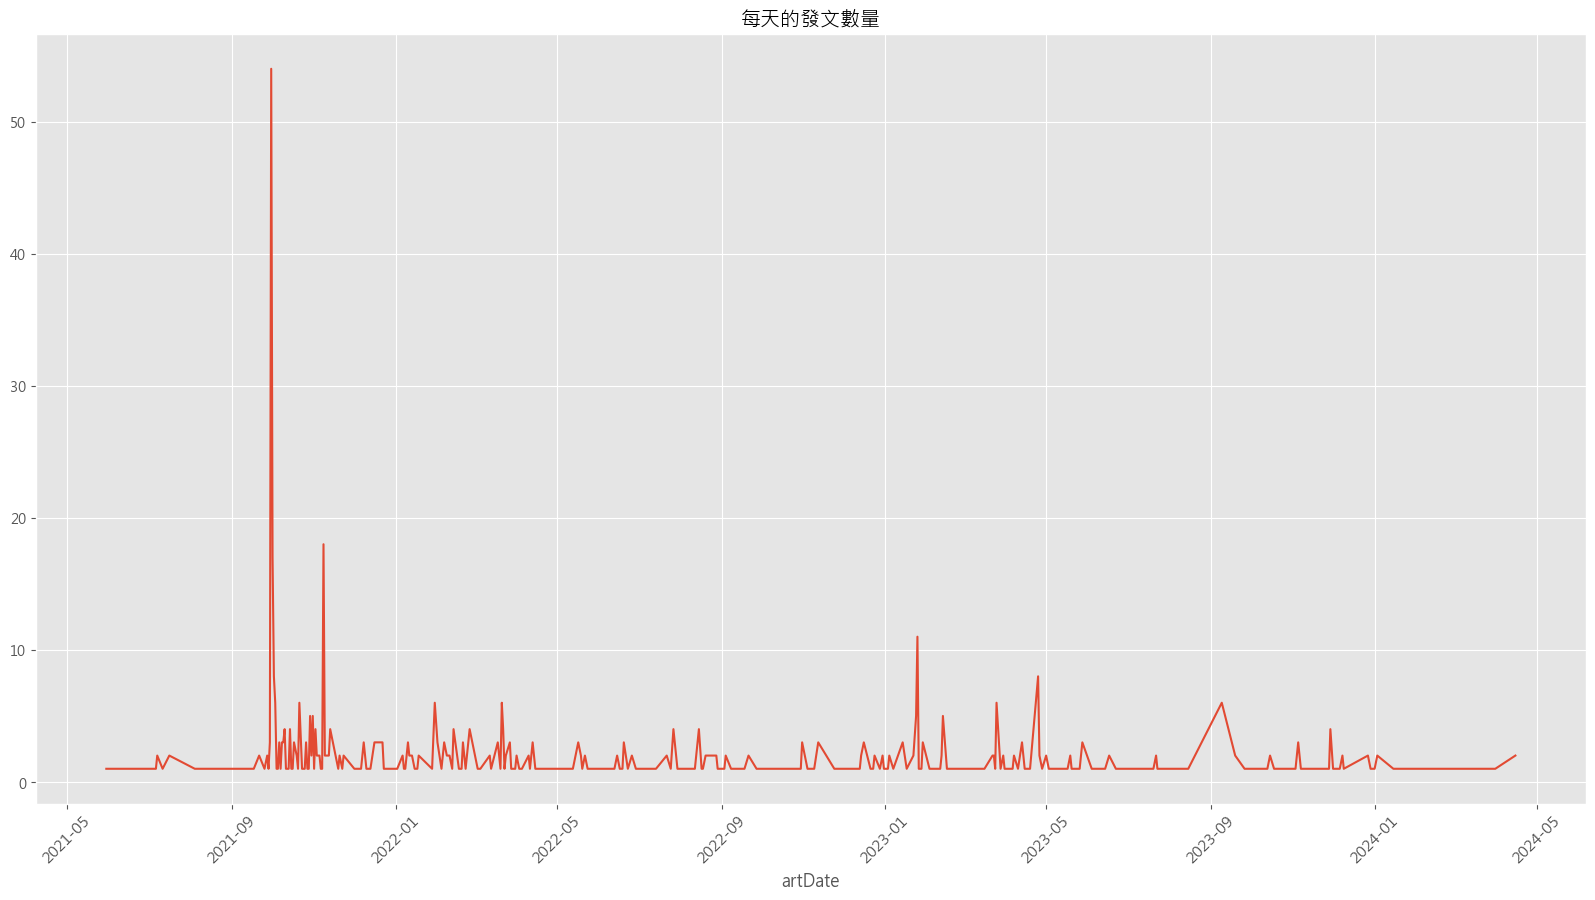

In [16]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(20,10))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())


*   可以看出2021年九月左右躺平相關的文章數量突然暴增，我們進一步針對當時文章調查發現：
    *   2021年4月：百度貼吧 一則 "躺平及是正義" 的貼文衝上熱搜，躺平該詞隨後襲捲中國各大社群平台。
    *   2021年5月：新冠疫情爆發發布三級緊戒。
    *   2021年9月：中國恆大風暴經濟低迷，躺平主義持續發酵。
    *   2021年9月 ~ 2022年1月：三級警戒不斷延長，許多服務業不堪虧損增加裁員或是延長無薪假，許多年輕人失去收入看不到未來。

In [17]:
# To use CPU:
ws = WS("data\data")
pos = POS("data\data")
ner = NER("data\data")

c:\Users\a8184\miniconda3\envs\SMA_new\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\a8184\miniconda3\envs\SMA_new\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\a8184\miniconda3\envs\SMA_new\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.n

### 3.2 使用CKIP進行自然語言處理

In [18]:
## 讀取文章
df = pd.read_csv('raw_data/Lie-Flat.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\r\n才開始注意到這部陸劇[沒有工作的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\r\n\r\n1.媒體來源:\r\n新唐人\r\n\r\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt


定義文字清理的相關function

In [19]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [20]:
# 自定義辭典
with open('./dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(3, {'不努力': 500.0, '不消費': 500.0}), (4, {'不想努力': 500.0, '放棄努力': 500.0})]


In [21]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [22]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 404.94740533828735


### 3.4 探索分析-POS

In [23]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,23515
5,D,13974
35,VC,8227
41,VH,7991
6,DE,4576
17,Nc,3520
32,VA,3519
29,P,3506
27,Nh,3391
38,VE,2750


C:\Users\a8184\AppData\Local\Temp\ipykernel_23532\293363437.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


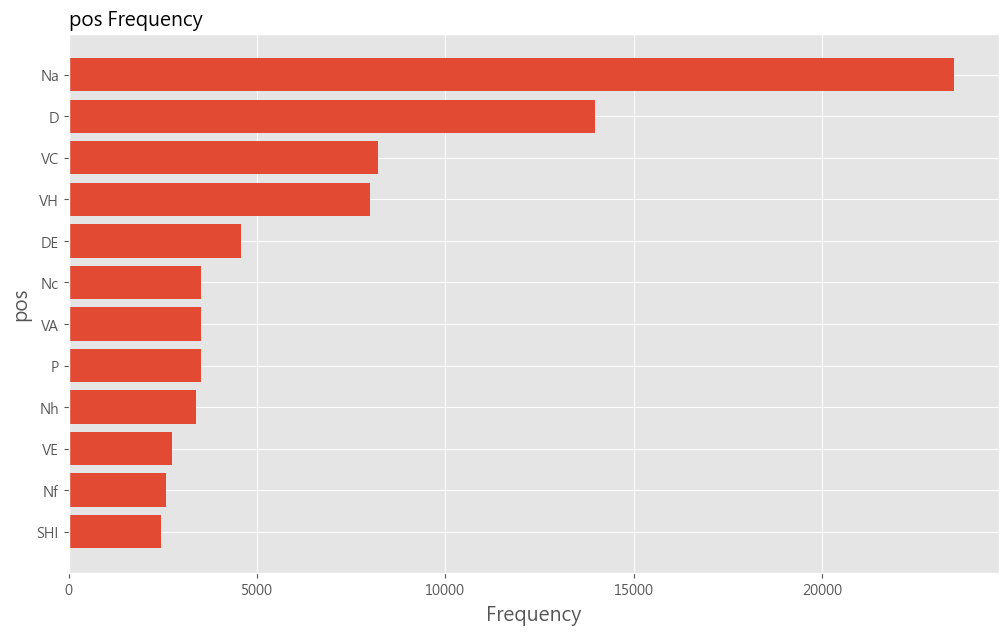

In [24]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('pos Frequency',loc ='left', size = 14)
ax.set_ylabel('pos', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

*    以上出現的是CKIP Transformers的不同的詞性，前三名為 Na: 普通名詞、D: 副詞以及 VC: 動作及物動詞


### 涉及到的名詞(Noun)

C:\Users\a8184\AppData\Local\Temp\ipykernel_23532\3574038685.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


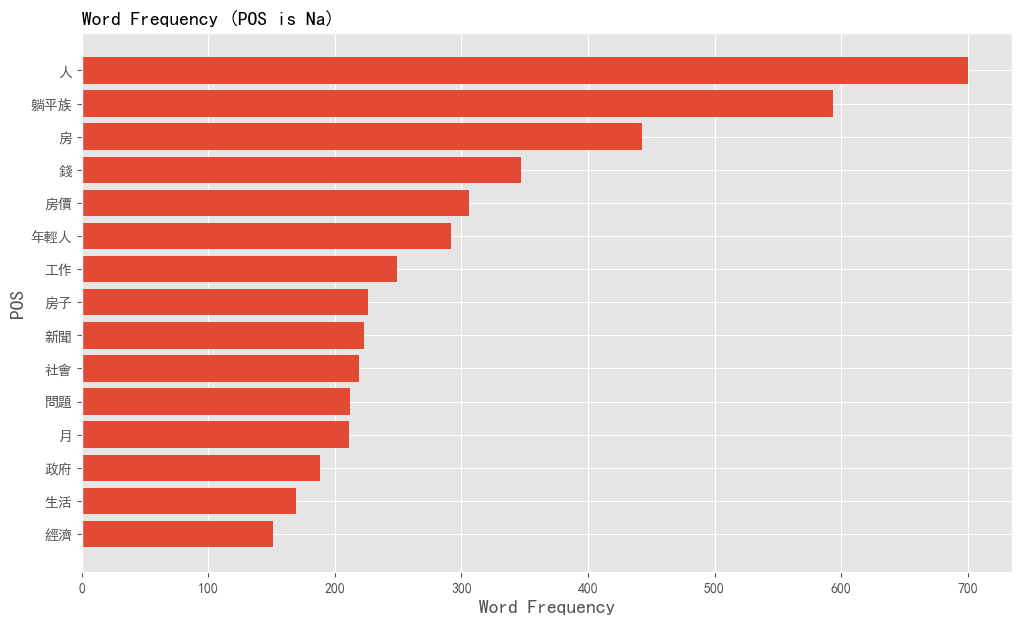

In [25]:
# 篩選pos為名詞的資料
l_noun = ["Na"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is Na)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)

C:\Users\a8184\AppData\Local\Temp\ipykernel_23532\4029434985.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


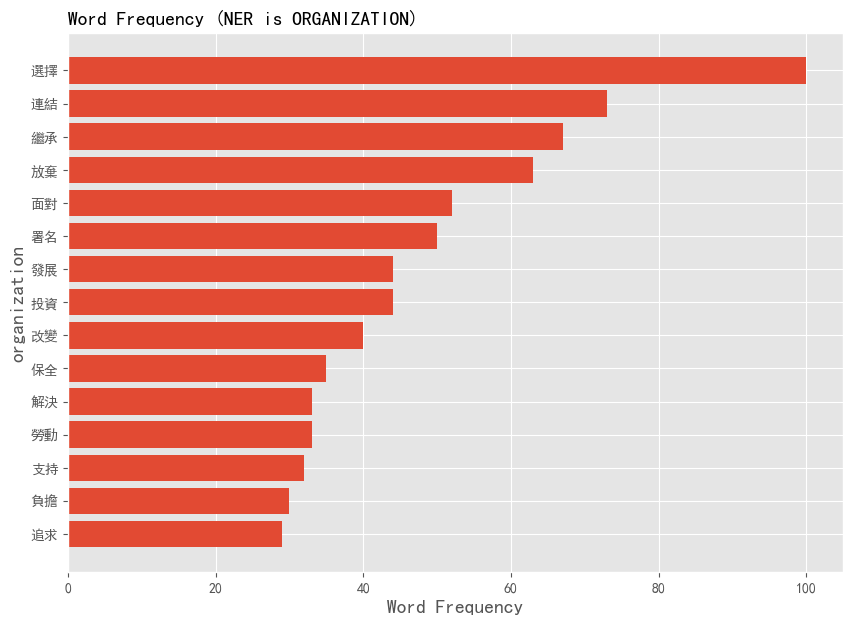

In [26]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)

word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

*    以上的圖表可以看出「繼承」和「放棄」出現的頻率蠻高的，反映了年輕人想要躺平的心態

In [27]:
keyword_list = ['政府']
price_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{price_selected.shape[0]}篇相關貼文")
price_selected.head(3)

政府：88篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,Re:[問卦]具體來說現在在等什麼,2021-06-06 18:30:04,leondemon,Gossiping,依據人性\r\n\r\n1. 人是自私的，自己的利益優先考量\r\n2. 別人的不幸甜如蜜\...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""jjjjjjs"", ""c...",27.53.17.75,2021-06-07 01:25:44,ptt
12,13,https://www.ptt.cc/bbs/Gossiping/M.1626432677....,[新聞]出境後號啕大哭23歲大陸男「牆國」出逃,2021-07-16 18:51:14,sunbysea,Gossiping,1.媒體來源:\r\n\r\n大紀元\r\n\r\n2.記者署名:\r\n\r\n責任編輯：...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""justic125"", ...",1.200.88.20,2021-07-17 00:45:21,ptt
16,17,https://www.ptt.cc/bbs/Gossiping/M.1629192932....,[新聞]中國推家庭教育法案以改善學業偏重問題,2021-08-17 17:35:30,z041l31l3,Gossiping,1.媒體來源:日本經濟新聞\r\n\r\n\r\n2.記者署名:北京-川手伊織\r\n\r\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""marktak"", ""c...",39.12.230.238,2021-08-18 00:57:16,ptt


## 4. 利用SnowNLP進行情緒分析

In [28]:
from snownlp import SnowNLP
sentence_table = pd.read_csv("./zh/sentence_table.csv") 

sentiment_date = pd.merge(sentence_table,price_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
165,5,依據人性,2021-06-06 18:30:04,ptt
166,5,人是自私的，自己的利益優先考量,2021-06-06 18:30:04,ptt
167,5,別人的不幸甜如蜜,2021-06-06 18:30:04,ptt
168,5,但是大家在等的都不樣,2021-06-06 18:30:04,ptt
169,5,所以中產階級在等,2021-06-06 18:30:04,ptt


In [29]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
165,5,依據人性,2021-06-06 18:30:04,ptt,0.871683
166,5,人是自私的，自己的利益優先考量,2021-06-06 18:30:04,ptt,0.954019
167,5,別人的不幸甜如蜜,2021-06-06 18:30:04,ptt,0.933026
168,5,但是大家在等的都不樣,2021-06-06 18:30:04,ptt,0.046343
169,5,所以中產階級在等,2021-06-06 18:30:04,ptt,0.785499


<Axes: >

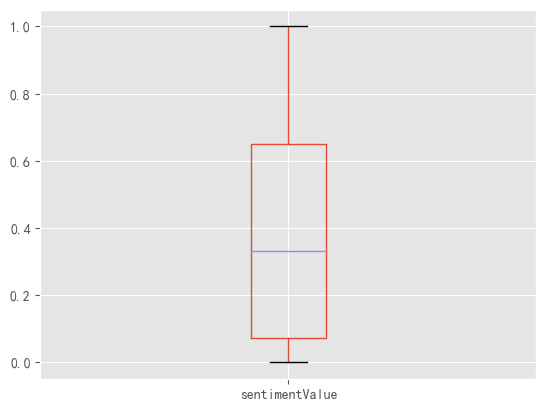

In [30]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [31]:
sent_date = sentiment_date.copy()
sent_date['artDate'] = pd.to_datetime(sent_date['artDate']).dt.to_period('M')

# 只保留包含'政府'的句子和 sentimentValue 小於 0.4 的資料
sent_date = sent_date[(sent_date['sentence'].str.contains('政府')) & (sent_date['sentimentValue'] < 0.4)]

# 分組並計算平均值，同時取得每個月的第一個sentence
sentiment_count = sent_date.groupby('artDate').agg({
    'sentimentValue': 'mean',  # 計算sentimentValue的平均值
    'sentence': 'first'       # 取得每個分組中的第一個sentence
}).reset_index()

# 顯示前幾行
sentiment_count.head(100)


,artDate,sentimentValue,sentence
0,2021-07,0.004140,裡靜坐，抗議警方暴行，要求政府回應他們的訴求
1,2021-08,0.041204,中國政府這樣親自加入家庭教育的原因，是因為意識到過剩的教育熱已成為嚴重的問題
2,2021-09,0.162288,沒時間在八卦版上雞蛋挑政府的骨頭
3,2021-10,0.040816,所以說真的要請政府社會住宅多蓋然後條件再放寬點，我相信年輕人就會很有感了
4,2021-11,0.109111,與其靠政府不如靠佛祖
5,2021-12,0.207213,不是政府不好，是你自己不爭氣
6,2022-01,0.074039,政府出手打炒房，想藉此抑制房價，從中國盛行的躺平主義也在台灣年級生間發酵
7,2022-02,0.206244,完整新聞標題政府為年輕人維護居住正義
8,2022-03,0.108995,賴清德說，政府有責任減輕年輕人的負擔，有積極在做，未來會繼續努力
9,2022-04,0.147320,不要懷疑政府打炒房的決心


我們查看含有政府且情緒值偏低的句子

確實看到其中含有許多對於年輕人對於政策的不滿

例如：
* 與其靠政府不如靠佛祖
* 台灣的房價漲不回頭，政府打房似乎越打越貴
* 對耶這樣想好像就沒有政府的事情了

In [32]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate,sentimentValue
0,2021-06,0.360551
1,2021-07,0.455106
2,2021-08,0.533279
3,2021-09,0.427272
4,2021-10,0.410435


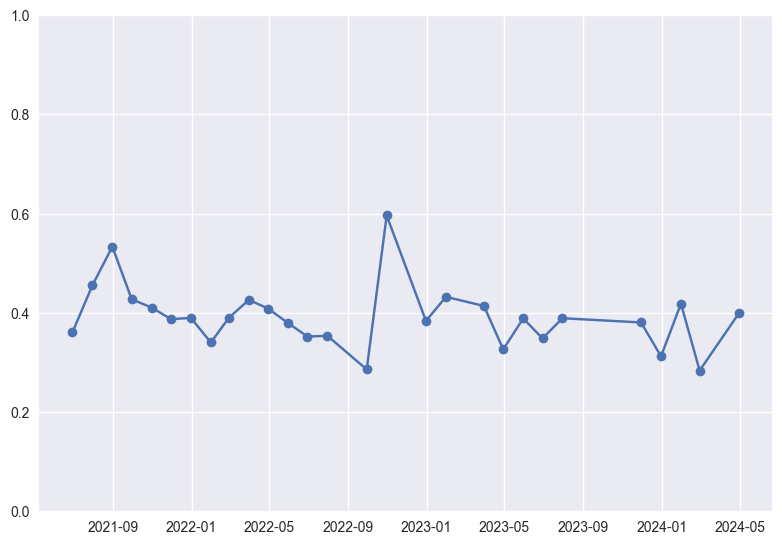

In [33]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn-v0_8') # or seaborn

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

## 5. TF-IDF
### 5.1 計算每個詞彙的TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 



In [34]:
# 每篇文章的總詞彙數
MetaData = df.copy()
MetaData.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\r\n才開始注意到這部陸劇[沒有工作的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\r\n\r\n1.媒體來源:\r\n新唐人\r\n\r\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,[問卦]我就爛有另一種說法嗎?,2021-06-04 20:36:41,eric112,Gossiping,在日本有草食男或啃老族\r\n\r\n現在中國忽然來了一個躺平族\r\n\r\n那有沒有其他...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""makinoyui"", ...",36.227.134.238,2021-06-05 01:20:55,ptt
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,Re:[問卦]具體來說現在在等什麼,2021-06-06 18:30:04,leondemon,Gossiping,依據人性\r\n\r\n1. 人是自私的，自己的利益優先考量\r\n2. 別人的不幸甜如蜜\...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""jjjjjjs"", ""c...",27.53.17.75,2021-06-07 01:25:44,ptt


In [35]:
# 移除網址格式
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
# 只留下中文字
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\r\n才開始注意到這部陸劇[沒有工作的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt,因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\r\n\r\n1.媒體來源:\r\n新唐人\r\n\r\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt,備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...


In [36]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [37]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [38]:
data = MetaData.copy()
# data.sentence
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

Building prefix dict from c:\Users\a8184\OneDrive\桌面\作品\躺平族資料探勘0\dict\dict.txt ...
Loading model from cache C:\Users\a8184\AppData\Local\Temp\jieba.uf0ca3734393a963fcf7189c3052e0a92.cache
Loading model cost 0.838 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一


In [39]:
# 每篇文章的總詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,42
1,https://www.ptt.cc/bbs/China-Drama/M.169899146...,96
2,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,680
3,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,6
4,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,41
...,...,...
620,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....,250
621,https://www.ptt.cc/bbs/prozac/M.1632232347.A.6...,89
622,https://www.ptt.cc/bbs/prozac/M.1667170649.A.7...,103
623,https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...,40


In [40]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1
...,...,...,...
36925,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,資料,1
36926,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,躺平,1
36927,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,預訂,1
36928,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,體力,1


In [41]:
lie_flat_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
lie_flat_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42
...,...,...,...,...
36925,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,資料,1,27
36926,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,躺平,1,27
36927,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,預訂,1,27
36928,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,體力,1,27


計算tf-idf值

In [42]:
# 計算tf
lie_flat_words_tf_idf = lie_flat_words.assign(tf = lie_flat_words.iloc[:,2]/lie_flat_words.iloc[:,3])
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381


In [43]:
# 計算每個詞彙出現在幾篇文章中
idf_df = lie_flat_words.groupby(['word'],as_index=False).size()
lie_flat_words_tf_idf = lie_flat_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381,1
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381,80
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381,35
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381,1
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381,1


In [44]:
# 計算idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(idf = lie_flat_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

lie_flat_words_tf_idf = lie_flat_words_tf_idf.drop(labels=['size'],axis=1)
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381,2.795880
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381,0.892790
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381,1.251812
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381,2.795880
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381,2.795880


In [45]:
# 計算tf*idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(tf_idf = lie_flat_words_tf_idf.iloc[:,4] * lie_flat_words_tf_idf.iloc[:,5])
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381,2.795880,0.066569
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381,0.892790,0.021257
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381,1.251812,0.029805
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381,2.795880,0.066569
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381,2.795880,0.066569


In [46]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = lie_flat_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))
group

artUrl  \
artUrl                                                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   3      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   4      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   7      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   8      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
...                                                                                                     ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 36906  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36908  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36912  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36913  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36921  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   

                                                         word  count  total  \
artUrl                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0       一部      1     42   
                                                   3       候選      1     42   
                                                   4       劇王      1     42   
                                                   7       受挫      1     42   
                                                   8       大雨      1     42   
...                                                       ...    ...    ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 36906   厭煩      1     27   
                                                   36908   很花      1     27   
                                                   36912   憂鬱      1     27   
                                                   36913  憂鬱症      1     27   
                                                   36921  精神力      1     27   

                                                                tf      idf  \
artUrl                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0      0.023810  2.79588   
                                                   3      0.023810  2.79588   
                                                   4      0.023810  2.79588   
                                                   7      0.023810  2.79588   
                                                   8      0.023810  2.79588   
...                                                            ...      ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 36906  0.037037  2.79588   
                                                   36908  0.037037  2.79588   
                                                   36912  0.037037  2.79588   
                                                   36913  0.037037  2.79588   
                                                   36921  0.037037  2.79588   

                                                            tf_idf  
artUrl                                                              
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0      0.066569  
                                                   3      0.066569  
                                                   4      0.066569  
                                                   7      0.066569  
                                                   8      0.066569  
...                                                            ...  
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA..

In [47]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                               
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0     一部  0.066569
                                                   3     候選  0.066569
                                                   4     劇王  0.066569
                                                   7     受挫  0.066569
                                                   8     大雨  0.066569
https://www.ptt.cc/bbs/China-Drama/M.1698991462... 110   金句  0.058248
                                                   46    人生  0.055799
                                                   66    愛情  0.048307
                                                   95    職場  0.043686
                                                   89    答案  0.038367
https://www.ptt.cc/bbs/Gossiping/M.1622344364.A... 279   火爆  0.032893
                                                   129   中共  0.031692
                                                   274   消費  0.028381
                                                   132   主義  0.023512
                                                   195   學者  0.020771

### 計算整個文集中較常 tf-idf 值高的字

In [48]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(lie_flat_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
4287,躺平,21
2009,年輕人,16
1175,台灣,15
2002,年級,13
805,八年級,13
1930,工作,12
100,七年級,12
1862,小孩,11
2327,房價,9
632,保全,9


## 6.透過結巴斷詞與N-gram幫助建立字典

### 6.1 Bigram

In [49]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [50]:
lie_flat_bigram = MetaData.copy()

lie_flat_bigram["word"] =lie_flat_bigram.sentence.apply(bigram_getToken)
lie_flat_bigram = lie_flat_bigram.explode('word')
lie_flat_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集 沒人開
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開 這一
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一 閒聊


#### 統計最常出現的bigram組合

In [51]:
# 計算每個組合出現的次數
lie_flat_bigram_count = lie_flat_bigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的bigram組合
fb_filter = list(lie_flat_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
lie_flat_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
1357,不婚 不生,76
19462,推錢 推錢,55
40272,青年 勞工,40
36703,躺平 躺平,39
36139,躺平 主義,31
35063,買房 買車,31
19388,推推 推推,30
19393,推推 推錢,27
30036,結婚 生子,25
19457,推錢 推推,24


### 6.2 Trigram

In [52]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [53]:
lie_flat_trigram = MetaData.copy()

lie_flat_trigram["word"] = lie_flat_trigram.sentence.apply(trigram_getToken)
lie_flat_trigram = lie_flat_trigram.explode('word')
lie_flat_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集 沒人開 這一
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開 這一 閒聊
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一 閒聊 一部


#### 統計最常出現的trigram組合

In [54]:
# 計算每個組合出現的次數
lie_flat_trigram_count = lie_flat_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
fb_filter = list(lie_flat_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
lie_flat_trigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
21023,推錢 推錢 推錢,27
1327,不可 轉載 備註,24
38842,躺平 不婚 不生,14
20910,推推 推推 推推,12
21021,推錢 推錢 推推,12
36692,請放 違者 刪除,11
41312,違者 刪除 來源,11
43289,需放 原始 不可,11
4888,備註 請放 違者,11
7936,原始 不可 轉載,11


根據 Bigram 以及 Trigram 新增一些段詞於lexicon.txt
* 連結網址
* 青年勞工
* 不可轉載

In [55]:
jieba.load_userdict('dict\lexicon.txt')

In [56]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')
data2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一


In [57]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

### 6.5 Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [58]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集 沒人開 這一 閒聊 一部 顛覆 都市 情感 富美 富帥 北上 生活 女二何 小雨 躺平...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\r\n才開始注意到這部陸劇[沒有工作的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt,因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...,滑到 工作 打工 金句 注意到 這部 陸劇 工作 總共 本來 打發 沒想到 看著 愛上 感覺...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\r\n\r\n1.媒體來源:\r\n新唐人\r\n\r\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt,備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...,備註 請放 違者 刪除 來源 唐人 署名 婷婷 標題 中國人 躺平 火爆 網路 當局 慌忙 ...


In [59]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一輩子,一間,七年級,上班,下去,下班,不可,不婚,不想,不生,...,需要,青年,青年勞工,面對,韭菜,頭期款,願意,顯示,高房價,高雄
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,6,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,0,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
621,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一輩子,一間,七年級,上班,下去,下班,不可,不婚,不想,...,需要,青年,青年勞工,面對,韭菜,頭期款,願意,顯示,高房價,高雄
0,一輩子,1.000000,-0.013480,0.017309,-0.032578,-0.008509,-0.021794,0.020812,0.085417,0.007620,...,0.008134,-0.022111,0.038587,0.041663,0.166200,-0.013936,0.094958,0.011356,0.129553,-0.021863
1,一間,-0.013480,1.000000,-0.006601,0.020818,-0.024546,0.034336,-0.007937,-0.051538,0.072708,...,-0.041795,-0.018431,-0.008461,-0.026138,0.045763,0.034621,0.003717,-0.008510,0.054366,0.100587
2,七年級,0.017309,-0.006601,1.000000,0.017053,-0.019856,-0.004047,-0.033417,0.069726,-0.009086,...,-0.032429,-0.022714,-0.016130,-0.030842,0.046033,0.019412,-0.003211,-0.026400,-0.026414,-0.017637
3,上班,-0.032578,0.020818,0.017053,1.000000,0.022401,0.538141,0.102237,0.039007,-0.006251,...,0.059448,0.058112,0.029624,0.013431,-0.017580,-0.002294,0.050310,0.068747,0.071090,0.047435
4,下去,-0.008509,-0.024546,-0.019856,0.022401,1.000000,-0.017250,-0.023875,0.013919,0.049655,...,0.056911,0.157407,-0.015747,0.117297,-0.030108,-0.047113,0.125856,0.103021,0.171062,-0.017427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,頭期款,-0.013936,0.034621,0.019412,-0.002294,-0.047113,0.000633,0.054380,-0.043265,-0.014299,...,0.025412,-0.035377,-0.018698,-0.028063,-0.023865,1.000000,0.018432,-0.030603,-0.040571,-0.020444
296,願意,0.094958,0.003717,-0.003211,0.050310,0.125856,-0.025380,0.043143,-0.004603,-0.010520,...,0.224412,0.015350,-0.007158,0.049733,-0.002378,0.018432,1.000000,0.083170,0.085038,0.044350
297,顯示,0.011356,-0.008510,-0.026400,0.068747,0.103021,-0.031894,0.205074,0.020966,0.030488,...,0.191893,0.316642,0.306658,0.193229,0.045288,-0.030603,0.083170,1.000000,0.127608,0.106539
298,高房價,0.129553,0.054366,-0.026414,0.071090,0.171062,-0.042282,0.143724,0.149712,0.104439,...,0.073400,0.305762,0.212880,0.397065,-0.000488,-0.040571,0.085038,0.127608,1.000000,0.226539


In [61]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
11628,署名,內文,1.000000
68438,內文,署名,1.000000
22702,男性,女性,0.998821
60675,女性,男性,0.998821
60676,女權,男性,0.995771
23002,男性,女權,0.995771
22576,女權,女性,0.995539
22875,女性,女權,0.995539
22851,反對,女權,0.987088
15376,女權,反對,0.987088


## 找出和「躺平」以及「政府」相關性最高的 10 的詞彙

In [62]:
lay_sum = word_cor_df[(word_cor_df["word1"] == "躺平")].sort_values(by = ['cor'], ascending = False).head(20)


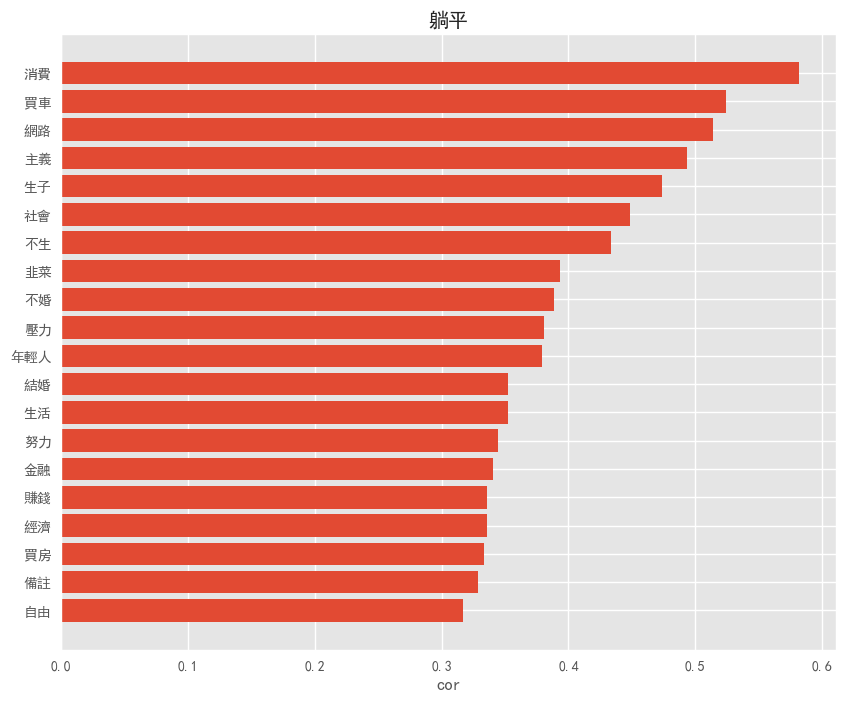

In [63]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.figure(figsize=(22,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('躺平')
plt.xlabel('cor')
plt.barh(lay_sum['word2'],lay_sum['cor'])
plt.gca().invert_yaxis()



plt.show()

### 使用詞彙關係圖畫出詞頻前60且相關性高於0.3的組合

In [64]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [65]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,薪水,上班,0.374361
1,不生,不婚,0.896847
2,買車,不婚,0.505111
3,躺平,不婚,0.388995
4,不婚,不生,0.896847
...,...,...,...
369,男性,需要,0.345500
370,社會,需要,0.373001
371,結婚,需要,0.312215
372,經濟,需要,0.368137


In [66]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

In [67]:
dict = __builtins__.dict

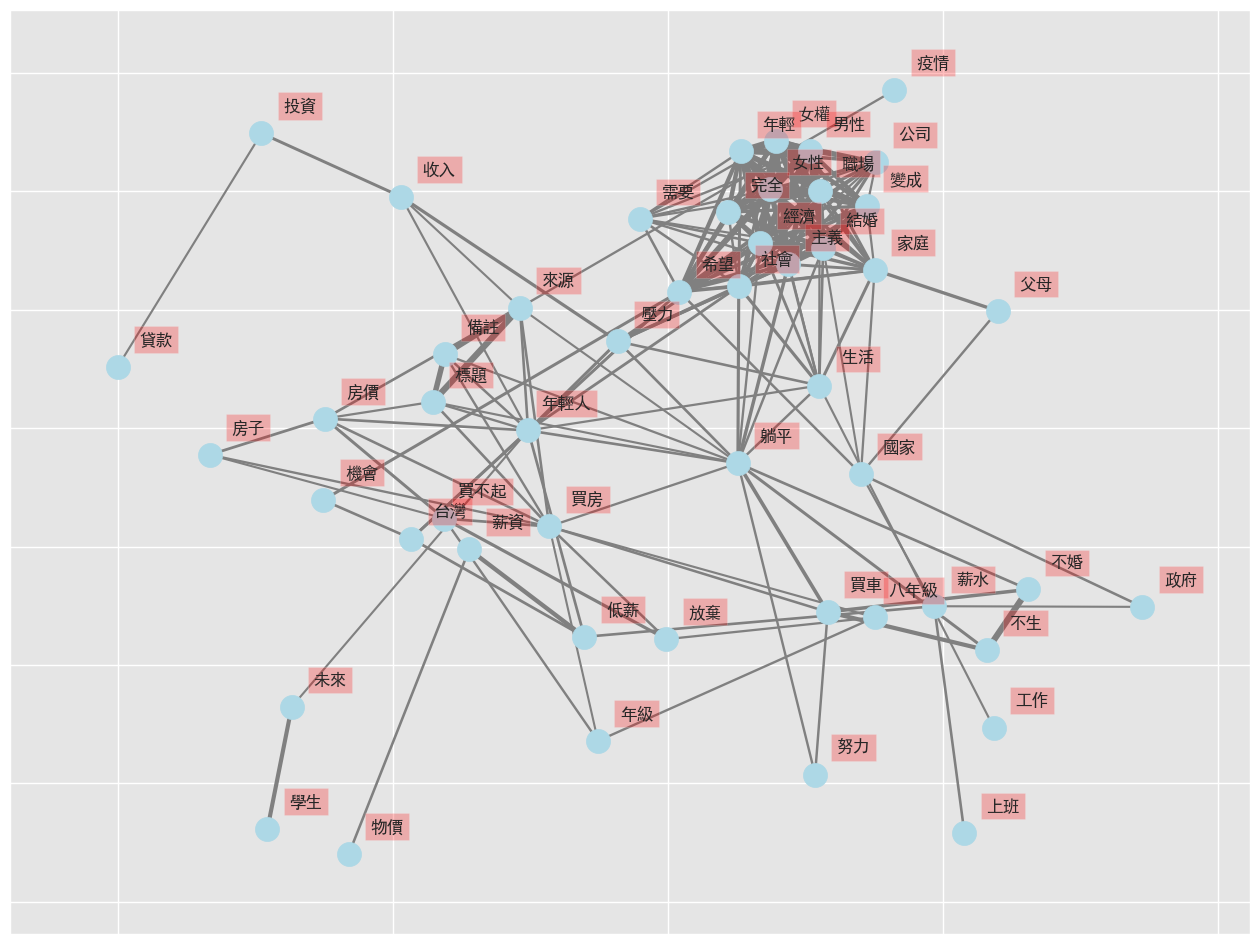

In [68]:
fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(g, k=0.5)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

## 7. 結論


* 我們透過每日發文數量趨勢圖找出躺平主義開始傳入台灣的時間，以及躺平主義2021年9月台灣引發熱意的原因
  * 2021年4月：百度貼吧 一則 "躺平及是正義" 的貼文衝上熱搜，躺平該詞隨後襲捲中國各大社群平台。
  * 2021年9月：中國恆大風暴經濟低迷，躺平主義持續發酵。
  * 2021年9月 ~ 2022年1月：三級警戒不斷延長，許多服務業不堪虧損增加裁員或是延長無薪假，許多年輕人失去收入看不到未來，躺平主義開始受到台灣年輕人關注。

* 透過 POS 挑出出現頻率前15的名詞，我們發現躺平主義跟台灣高房價低薪問題存在很大關聯。
  
* 透過Pearson correlation 計算出詞彙相關性並取出與躺平相關性前20的字詞，結合辭彙關係圖，我們可以推估出台灣年輕人躺平的理念就是不不買房不結婚不生小孩以及崇尚自由

總結：台灣年輕人躺平是因為他們處與低薪以及面對台灣高房價的原因，造成他們認為即便如何努力都不法達到人生目標，所以他們選擇躺平選擇不再追求買房成家，他們寧願享受即時行樂以及自由也不願意背負龐大的房貸壓力。
